In [10]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 128
max_length = 128
num_epochs = 20
learning_rate = 3e-4

Using device: cuda


In [12]:
tokenizerPath = "tokenizer_path"
df = pd.read_csv("final_dataset.csv")
modelPath = "final_dataset_best_bengali_transformer.pt"

D:\Temp\ipykernel_22896\743332305.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
D:\Temp\ipykernel_22896\743332305.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
D:\Temp\ipykernel_22896\743332305.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")


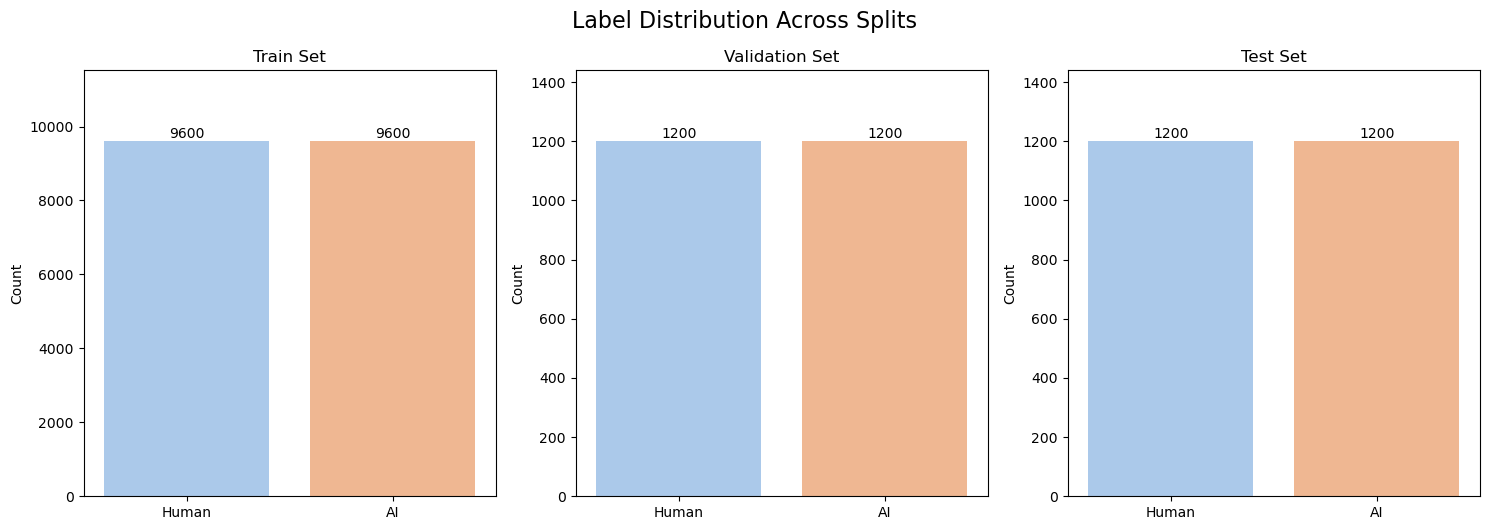

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = df[df['label'].isin(['human', 'ai'])]  # Filter unwanted labels
label_map = {"human": 0, "ai": 1}
df["label"] = df["label"].map(label_map)

# Split dataset
texts, labels = df["text"].tolist(), df["label"].tolist()
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Prepare data for plotting
splits = {
    "Train": train_labels,
    "Validation": val_labels,
    "Test": test_labels,
}

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (split_name, split_labels) in enumerate(splits.items()):
    counts = pd.Series(split_labels).value_counts().sort_index()
    class_names = ['Human', 'AI']
    sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
    axs[i].set_title(f"{split_name} Set")
    axs[i].set_ylabel("Count")
    axs[i].set_ylim(0, max(counts.values) * 1.2)
    for j, count in enumerate(counts.values):
        axs[i].text(j, count + 2, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle("Label Distribution Across Splits", fontsize=16, y=1.05)
plt.show()


# Tokenizer

In [14]:
if not os.path.exists(tokenizerPath):
    os.makedirs(tokenizerPath)  # Ensure the directory exists
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
    tokenizer.save_model(tokenizerPath)
else:
    tokenizer = ByteLevelBPETokenizer(f"{tokenizerPath}/vocab.json", f"{tokenizerPath}/merges.txt")

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids))
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

train_dataset = BengaliTextDataset(train_texts, train_labels)
val_dataset = BengaliTextDataset(val_texts, val_labels)
test_dataset = BengaliTextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Custom Class

In [15]:
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)


# Training Setup

In [16]:
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Scheduler (optional warmup + decay)
from transformers import get_cosine_schedule_with_warmup
warmup_steps = 500
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)


In [17]:
def count_all_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total:,}")
    print(f"Trainable Parameters: {trainable:,}")
    print(f"Non-trainable Parameters: {total - trainable:,}")

# Usage:
count_all_parameters(model)


Total Parameters: 29,391,106
Trainable Parameters: 29,391,106
Non-trainable Parameters: 0


# Train

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# === Initialize tracking ===
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0
best_epoch = 0
best_preds, best_labels = None, None
num_epochs = 1000
patience = 20
early_stop_counter = 0

# === Training Loop ===
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # --- Training ---
    model.train()
    total_train_loss = 0
    correct, total = 0, 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_val_loss / len(val_loader)
    val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # --- Save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_preds = all_preds
        best_labels = all_labels
        torch.save(model.state_dict(), modelPath)
        print("✅ Saved new best model.")
        early_stop_counter = 0  # reset early stop counter
    else:
        early_stop_counter += 1
        print(f"⚠️  No improvement. Early stop counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print(f"\n⏹️ Early stopping at epoch {epoch+1}. Best epoch was {best_epoch+1}.")
        break



Epoch 1/1000


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]c:\Users\Jim\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.15it/s]


Train Loss: 0.5402 | Train Acc: 0.7323
Val   Loss: 0.3533 | Val   Acc: 0.9075
✅ Saved new best model.

Epoch 2/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.37it/s]


Train Loss: 0.3697 | Train Acc: 0.8966
Val   Loss: 0.3111 | Val   Acc: 0.9333
✅ Saved new best model.

Epoch 3/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.45it/s]


Train Loss: 0.2989 | Train Acc: 0.9420
Val   Loss: 0.2972 | Val   Acc: 0.9379
✅ Saved new best model.

Epoch 4/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.42it/s]


Train Loss: 0.2760 | Train Acc: 0.9576
Val   Loss: 0.2736 | Val   Acc: 0.9579
✅ Saved new best model.

Epoch 5/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.28it/s]


Train Loss: 0.2426 | Train Acc: 0.9770
Val   Loss: 0.2872 | Val   Acc: 0.9554
⚠️  No improvement. Early stop counter: 1/20

Epoch 6/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.35it/s]


Train Loss: 0.2296 | Train Acc: 0.9845
Val   Loss: 0.2728 | Val   Acc: 0.9663
✅ Saved new best model.

Epoch 7/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.28it/s]


Train Loss: 0.2269 | Train Acc: 0.9861
Val   Loss: 0.2850 | Val   Acc: 0.9533
⚠️  No improvement. Early stop counter: 1/20

Epoch 8/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.32it/s]


Train Loss: 0.2214 | Train Acc: 0.9888
Val   Loss: 0.2718 | Val   Acc: 0.9654
⚠️  No improvement. Early stop counter: 2/20

Epoch 9/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Train Loss: 0.2158 | Train Acc: 0.9914
Val   Loss: 0.2685 | Val   Acc: 0.9671
✅ Saved new best model.

Epoch 10/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Train Loss: 0.2122 | Train Acc: 0.9934
Val   Loss: 0.2943 | Val   Acc: 0.9613
⚠️  No improvement. Early stop counter: 1/20

Epoch 11/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.46it/s]


Train Loss: 0.2101 | Train Acc: 0.9952
Val   Loss: 0.2727 | Val   Acc: 0.9663
⚠️  No improvement. Early stop counter: 2/20

Epoch 12/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.48it/s]


Train Loss: 0.2051 | Train Acc: 0.9979
Val   Loss: 0.2723 | Val   Acc: 0.9683
✅ Saved new best model.

Epoch 13/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.45it/s]


Train Loss: 0.2043 | Train Acc: 0.9979
Val   Loss: 0.2929 | Val   Acc: 0.9625
⚠️  No improvement. Early stop counter: 1/20

Epoch 14/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.49it/s]


Train Loss: 0.2044 | Train Acc: 0.9980
Val   Loss: 0.2910 | Val   Acc: 0.9633
⚠️  No improvement. Early stop counter: 2/20

Epoch 15/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.45it/s]


Train Loss: 0.2032 | Train Acc: 0.9987
Val   Loss: 0.2788 | Val   Acc: 0.9688
✅ Saved new best model.

Epoch 16/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.38it/s]


Train Loss: 0.2024 | Train Acc: 0.9990
Val   Loss: 0.2958 | Val   Acc: 0.9637
⚠️  No improvement. Early stop counter: 1/20

Epoch 17/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Train Loss: 0.2023 | Train Acc: 0.9990
Val   Loss: 0.2811 | Val   Acc: 0.9675
⚠️  No improvement. Early stop counter: 2/20

Epoch 18/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Train Loss: 0.2020 | Train Acc: 0.9992
Val   Loss: 0.2775 | Val   Acc: 0.9700
✅ Saved new best model.

Epoch 19/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.38it/s]


Train Loss: 0.2019 | Train Acc: 0.9992
Val   Loss: 0.2778 | Val   Acc: 0.9688
⚠️  No improvement. Early stop counter: 1/20

Epoch 20/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.38it/s]


Train Loss: 0.2019 | Train Acc: 0.9992
Val   Loss: 0.2776 | Val   Acc: 0.9700
⚠️  No improvement. Early stop counter: 2/20

Epoch 21/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.41it/s]


Train Loss: 0.2020 | Train Acc: 0.9992
Val   Loss: 0.2775 | Val   Acc: 0.9704
✅ Saved new best model.

Epoch 22/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Train Loss: 0.2021 | Train Acc: 0.9991
Val   Loss: 0.2790 | Val   Acc: 0.9683
⚠️  No improvement. Early stop counter: 1/20

Epoch 23/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.39it/s]


Train Loss: 0.2020 | Train Acc: 0.9992
Val   Loss: 0.2781 | Val   Acc: 0.9688
⚠️  No improvement. Early stop counter: 2/20

Epoch 24/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.39it/s]


Train Loss: 0.2020 | Train Acc: 0.9992
Val   Loss: 0.2988 | Val   Acc: 0.9621
⚠️  No improvement. Early stop counter: 3/20

Epoch 25/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.35it/s]


Train Loss: 0.2028 | Train Acc: 0.9988
Val   Loss: 0.2765 | Val   Acc: 0.9696
⚠️  No improvement. Early stop counter: 4/20

Epoch 26/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.37it/s]


Train Loss: 0.2027 | Train Acc: 0.9988
Val   Loss: 0.2781 | Val   Acc: 0.9692
⚠️  No improvement. Early stop counter: 5/20

Epoch 27/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.40it/s]


Train Loss: 0.2073 | Train Acc: 0.9964
Val   Loss: 0.2767 | Val   Acc: 0.9679
⚠️  No improvement. Early stop counter: 6/20

Epoch 28/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.37it/s]


Train Loss: 0.2093 | Train Acc: 0.9953
Val   Loss: 0.2759 | Val   Acc: 0.9671
⚠️  No improvement. Early stop counter: 7/20

Epoch 29/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.40it/s]


Train Loss: 0.2127 | Train Acc: 0.9938
Val   Loss: 0.2698 | Val   Acc: 0.9717
✅ Saved new best model.

Epoch 30/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.42it/s]


Train Loss: 0.2119 | Train Acc: 0.9945
Val   Loss: 0.2750 | Val   Acc: 0.9654
⚠️  No improvement. Early stop counter: 1/20

Epoch 31/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.41it/s]


Train Loss: 0.2130 | Train Acc: 0.9933
Val   Loss: 0.3004 | Val   Acc: 0.9625
⚠️  No improvement. Early stop counter: 2/20

Epoch 32/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Train Loss: 0.2128 | Train Acc: 0.9933
Val   Loss: 0.3357 | Val   Acc: 0.9454
⚠️  No improvement. Early stop counter: 3/20

Epoch 33/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.40it/s]


Train Loss: 0.2404 | Train Acc: 0.9801
Val   Loss: 0.3458 | Val   Acc: 0.9279
⚠️  No improvement. Early stop counter: 4/20

Epoch 34/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.46it/s]


Train Loss: 0.4055 | Train Acc: 0.8605
Val   Loss: 0.6942 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 5/20

Epoch 35/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.41it/s]


Train Loss: 0.6945 | Train Acc: 0.5037
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 6/20

Epoch 36/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.44it/s]


Train Loss: 0.6934 | Train Acc: 0.5031
Val   Loss: 0.6932 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 7/20

Epoch 37/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.40it/s]


Train Loss: 0.6933 | Train Acc: 0.5010
Val   Loss: 0.6932 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 8/20

Epoch 38/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.50it/s]


Train Loss: 0.6933 | Train Acc: 0.4971
Val   Loss: 0.6932 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 9/20

Epoch 39/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.49it/s]


Train Loss: 0.6933 | Train Acc: 0.5034
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 10/20

Epoch 40/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.42it/s]


Train Loss: 0.6932 | Train Acc: 0.4920
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 11/20

Epoch 41/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.45it/s]


Train Loss: 0.6932 | Train Acc: 0.4961
Val   Loss: 0.6932 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 12/20

Epoch 42/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.50it/s]


Train Loss: 0.6932 | Train Acc: 0.5000
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 13/20

Epoch 43/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.45it/s]


Train Loss: 0.6932 | Train Acc: 0.5001
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 14/20

Epoch 44/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.43it/s]


Train Loss: 0.6932 | Train Acc: 0.4978
Val   Loss: 0.6932 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 15/20

Epoch 45/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.44it/s]


Train Loss: 0.6932 | Train Acc: 0.4964
Val   Loss: 0.6932 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 16/20

Epoch 46/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.45it/s]


Train Loss: 0.6931 | Train Acc: 0.4966
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 17/20

Epoch 47/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.48it/s]


Train Loss: 0.6932 | Train Acc: 0.4997
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 18/20

Epoch 48/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.41it/s]


Train Loss: 0.6932 | Train Acc: 0.5001
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 19/20

Epoch 49/1000


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.44it/s]

Train Loss: 0.6931 | Train Acc: 0.5065
Val   Loss: 0.6931 | Val   Acc: 0.5000
⚠️  No improvement. Early stop counter: 20/20

⏹️ Early stopping at epoch 49. Best epoch was 29.


# Plot

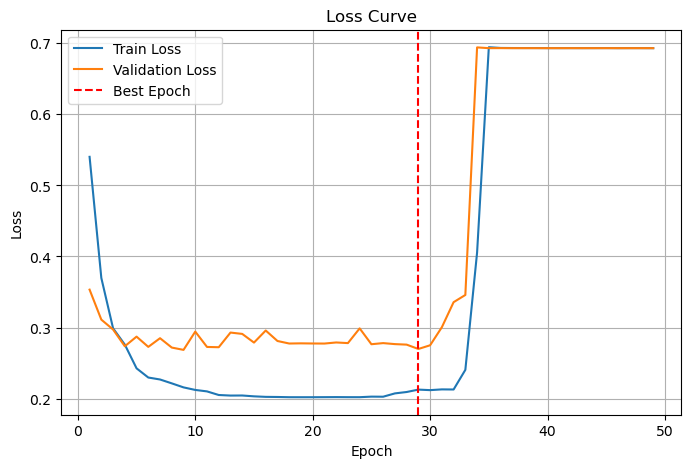

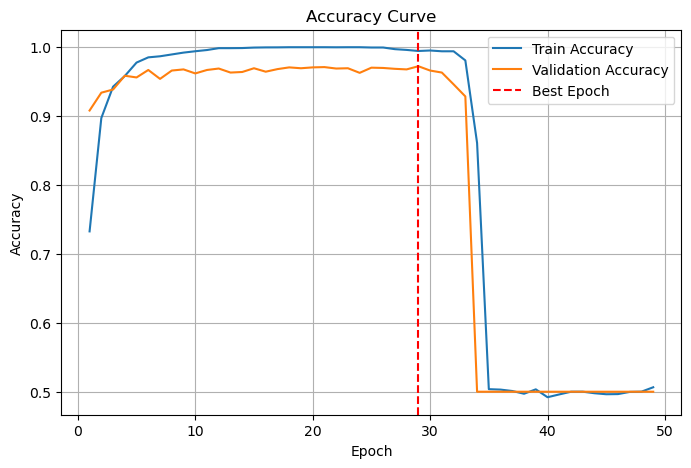

In [18]:
# === Plotting Loss & Accuracy ===
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.axvline(best_epoch + 1, linestyle='--', color='r', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig("loss_graph.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.axvline(best_epoch + 1, linestyle='--', color='r', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_graph.png")
plt.show()


# Evaluate Test Set


🔍 Final Evaluation on Test Set:


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 13.32it/s]


Test Loss: 0.2846, Test Accuracy: 0.9658


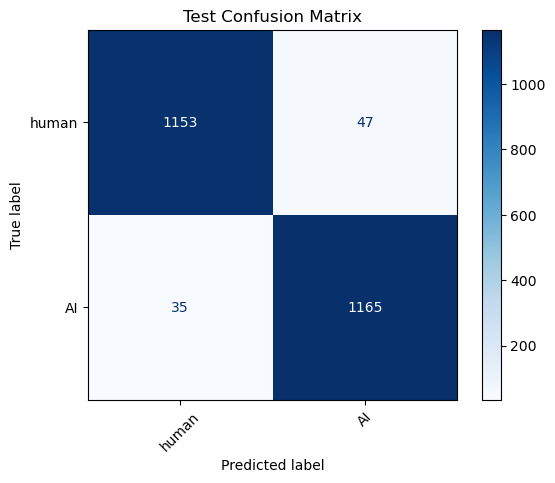


Classification Report:
              precision    recall  f1-score   support

       human     0.9705    0.9608    0.9657      1200
          AI     0.9612    0.9708    0.9660      1200

    accuracy                         0.9658      2400
   macro avg     0.9659    0.9658    0.9658      2400
weighted avg     0.9659    0.9658    0.9658      2400



In [19]:
# Load best model
model.load_state_dict(torch.load("final_dataset_best_bengali_transformer.pt"))
model.eval()

# Evaluate on test set
def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(loader), acc, all_preds, all_labels

print("\n🔍 Final Evaluation on Test Set:")
test_loss, test_acc, test_preds, test_labels = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion Matrix & Classification Report
class_names = ["human", "AI"]

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Test Confusion Matrix")
plt.grid(False)
plt.savefig("confusion_matrix.png")
plt.show()

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))


# Testing Random Text

In [18]:
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Instantiate model with correct vocab size
model = CustomTransformer(vocab_size=vocab_size).to(device)

# ✅ Load model weights
model.load_state_dict(torch.load(modelPath, map_location=device))


def predict_paragraph(text):
    model.eval()
    
    # Tokenize the input text using encode
    encoding = tokenizer.encode(text)
    
    # Prepare input_ids and attention_mask
    input_ids = encoding.ids[:max_length] + [0] * (max_length - len(encoding.ids)) if len(encoding.ids) < max_length else encoding.ids[:max_length]
    attention_mask = [1] * min(len(encoding.ids), max_length) + [0] * (max_length - len(encoding.ids))
    
    # Convert to PyTorch tensors and add batch dimension
    input_ids = torch.tensor([input_ids]).to(device)
    attention_mask = torch.tensor([attention_mask]).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
        # Get the predicted class index
        pred_idx = torch.argmax(outputs, dim=1).item()
    
    label_map = {0: "Human", 1: "AI"}
    # Get the predicted label and probabilities
    predicted_label = label_map[pred_idx]
    human_prob = probs[0] * 100  # Convert to percentage
    ai_prob = probs[1] * 100     # Convert to percentage
    
    return {
        "prediction": predicted_label,
        "human_probability": f"{human_prob:.2f}%",
        "ai_probability": f"{ai_prob:.2f}%"
    }

# Test with a sample text
sample_text = "বাংলাদেশের স্বাধীনতা যুদ্ধ একটি গৌরবোজ্জ্বল অধ্যায়। এই যুদ্ধে লক্ষ লক্ষ মানুষ শহীদ হয়।"
result = predict_paragraph(sample_text)
print(f"Prediction: {result['prediction']}")
print(f"Human Probability: {result['human_probability']}")
print(f"AI Probability: {result['ai_probability']}")

Prediction: Human
Human Probability: 96.61%
AI Probability: 3.39%


c:\Users\Jim\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


In [23]:
# Test with a sample text
sample_text = "চলচ্চিত্র অভিনেতা, পরিচালক ও প্রযোজক মাসুদ পারভেজ ওরফে সোহেল রানা একজন বীর মুক্তিযোদ্ধা। বাংলাদেশের মহান মুক্তিযুদ্ধের ইতিহাসের সঙ্গে জড়িয়ে থাকা ‘ওরা ১১ জন’ চলচ্চিত্রের প্রযোজক তিনি। ছবিটিতে মুক্তিযোদ্ধাদের দিয়ে অভিনয় করিয়েছিলেন নির্মাতা-প্রযোজক। পাকিস্তানি হানাদার বাহিনীর বিরুদ্ধে রক্তক্ষয়ী যুদ্ধ শেষে একাত্তরের ডিসেম্বরে রণাঙ্গন থেকে অস্ত্র হাতে ঘরে ফিরেছিলেন বীর মুক্তিযোদ্ধারা। সেই অস্ত্র নিয়েই ক্যামেরার সামনে দাঁড়িয়েছিলেন খসরু, মুরাদ, হেলাল, বেবি, নান্টু, ওলীন, মঞ্জু, আতা, ফিরোজ, আবু, আলতাফরা। যুদ্ধবিধ্বস্ত বাংলাদেশের প্রতিকূল পরিবেশে তখন সিনেমা নির্মাণ করা সহজ ছিল না। কিন্তু সেই অসাধ্য সাধন করেছিলেন দুই বন্ধু—প্রযোজক মাসুদ পারভেজ সোহেল রানা ও পরিচালক চাষী নজরুল ইসলাম। কিন্তু আজ এক ফেসবুক পোস্টে সোহেল রানা লিখেছেন, নিজের মুক্তিযোদ্ধা পরিচয় আর মুক্তিযোদ্ধা সনদ নিয়ে অনুতপ্ত তিনি।"
result = predict_paragraph(sample_text)
print(f"Prediction: {result['prediction']}")
print(f"Human Probability: {result['human_probability']}")
print(f"AI Probability: {result['ai_probability']}")

Prediction: AI
Human Probability: 3.87%
AI Probability: 96.13%


In [24]:
# Test with a sample text
sample_text = """ফেসবুক কমেন্ট বাংলা হলো ছেলে-মেয়েদের স্ট্যাটাস, কাভার ফটো বা প্রোফাইল ফটোতে তাদের বন্ধুদের ভালো-মন্দ, মজার বা প্রশংসাসূচক কমেন্ট করার একটি সাধারণ উপায়।

অনেকেই সময় বাঁচাতে রেডি টেমপ্লেট বা সুন্দর ফেসবুক কমেন্ট খুঁজে থাকেন। তাদের কথা মাথায় রেখে এই লেখায় আমরা নিয়ে এসেছি অসাধারণ ১০০+ ফেসবুক কমেন্ট, যা দিয়ে আপনি সহজেই মজার ও হাস্যকর পরিবেশ তৈরি করতে বা মেয়েদের ইম্প্রেস করার জন্যে প্রশংসা করতে পারবেন।

এই কমেন্টগুলো কপি বাটনে ক্লিক করে খুব সহজেই আপনার বন্ধু বা বান্ধবীর পোস্টে কমেন্ট করতে পারবেন।

তাহলে আর অপেক্ষা কেন? চলুন দেখে নেওয়া যাক নতুন বছরের সেরা ফানি ও অসাধারণ সব ফেসবুক কমেন্ট।"""
result = predict_paragraph(sample_text)
print(f"Prediction: {result['prediction']}")
print(f"Human Probability: {result['human_probability']}")
print(f"AI Probability: {result['ai_probability']}")

Prediction: Human
Human Probability: 96.62%
AI Probability: 3.38%


In [25]:
# Test with a sample text
sample_text = """প্ৰচন্ড শীত। মাঘের প্রথম। রাত দেড়টা। সেগুনবাগান। সমস্ত এলাকাটা ঘুমে অচেতন। জন প্রাণীর সাড়াশব্দ নেই। কেবল টহলদার নাইট গার্ড টহল দিয়ে ফিরছে। মাঝে মাঝে হুইল বাজাচ্ছে, সাথে সাথেই দূর থেকে ক্ষীণ প্রত্যুত্তর আসছে ভেসে। খট খট খট। টহলদারের লাঠির শব্দে রাত্রি আরও নিঝুম হয়ে আসে। রাস্তার পাশে সারি সারি লাইটপোস্টের আলোর চারধারে অনেকগুলো পোকা অনবরত ঘোরে। এমনি সময় দেখা গেল একখানি কালো শেভ্রোলে গাড়ি সামনের বহুদূর পর্যন্ত আলোকিত করে দ্রুত এগিয়ে আসছে। গাড়িটা কাছে এলে নাম্বার প্লেটের দিকে নজর যেতেই টহলদারের শিরদাঁড়া খাড়া হয়ে গেল। সশব্দে জুতো ঠুকে স্যালুট করলো সে। সিটি এস. পি.-র গাড়ি। ভিতরটা অন্ধকার। কেউ মাথা নাড়লো কিনা বোঝা গেল না। গাড়ি সমান গতিতে এগিয়ে গোল সামনে। গাড়িটা এসে থামলো একটা একতলা বাড়ির সামনে। এদিকটা অন্ধকার। মৃদু গর্জন করে এঞ্জিনটা বন্ধ হয়ে গেল। একজন ওভারকোট পরা লোক নামলো গাড়ি থেকে। নিঃশব্দে আগন্তুক এগিয়ে গেল বাড়িটার দিকে। হাতে তার ছোটো একটা বাক্স। লোকালয় থেকে কিছু দূরে বাড়িটা। অনেকদিনের পুরোনো বাড়ি, কিন্তু এখনও বেশ মজবুত আছে। বাড়ির সামনে খানিকটা বাগান। এলোমেলো করে অনেক ফুলগাছ লাগানো। মাঝে মাঝে পেয়ারা, জামরুল আর আম-কাঠালের গাছ। সবটা মিলে জঙ্গল বলে বোধ হয়। তারকাটা দিয়ে ঘেরা বাগানটা। ছোট একটা লোহার গেট আছে বাড়িতে ঢুকবার জন্যে। কোনও শব্দ না করে গেট খুললো লোকটা। একবার চারদিকে চাইলো, তারপর ঢুকে পড়লো বাগানের ভিতর। সোজা এগিয়ে গেল সে বাড়িটার দিকে। সব কটা দরজাই বন্ধ ভিতর থেকে। কিছুক্ষণ চুপ করে কি যেন ভাবলো আগন্তুক, তারপর একটা জানালার পাশে এসে দাঁড়ালো। মোটা শিক দেয়া জানালা। বেডরুম। সমস্ত ঘরটার মধ্যে কেবল এই জানালাই খোলা। হাতের বাক্স খুলে ফেললো লোকটা। ওটা কিসের যেন একটা যন্ত্র। ক্যামেরার মতো দেখতে। খানিকক্ষণ নাড়াচাড়া করে রেগুলেট করে নিয়ে যন্ত্রটার মুখ শিকের নিচের দিকে ধরে একটা বোতাম টিপতেই মুহুর্তে আশ্চর্যজনক ভাবে গলে তেল লোহার গরাদ। এইভাবে সব কটা গরাদই গলিয়ে ফেললো আগন্তুক। তারপর অবলীলাক্রমে একটা একটা করে সব শিক বাঁকিয়ে উপর দিকে তুলে দিলো।"""
result = predict_paragraph(sample_text)
print(f"Prediction: {result['prediction']}")
print(f"Human Probability: {result['human_probability']}")
print(f"AI Probability: {result['ai_probability']}")

Prediction: Human
Human Probability: 96.60%
AI Probability: 3.40%


In [26]:
# Test with a sample text
sample_text = """আমার নাম সাকিব। আমি নরত্থ সাউথ বিসশবেদ্দালয়ে পরি। আমার পরা লিখা করতে ভাল লাগে না। তাও আমার পরীক্ষার জন্য অনেক পড়াশোনা করতে হয়।"""
result = predict_paragraph(sample_text)
print(f"Prediction: {result['prediction']}")
print(f"Human Probability: {result['human_probability']}")
print(f"AI Probability: {result['ai_probability']}")

Prediction: Human
Human Probability: 96.61%
AI Probability: 3.39%


# About Model

In [19]:
# --- Model info ---
from transformers import AutoConfig

# Print model architecture
print("\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Print model configuration
config = AutoConfig.from_pretrained("sagorsarker/bangla-bert-base")
print("\nModel configuration:")
print(config)



Model architecture:
CustomTransformer(
  (embedding): Embedding(20077, 512)
  (position_embedding): Embedding(128, 512)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3,

c:\Users\Jim\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Model configuration:
BertConfig {
  "_name_or_path": "sagorsarker/bangla-bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 102025
}

